In [4]:
import os
import sys

from  IPython.core.debugger import Pdb 


sys.path.append("./exp/20220428/utils")

import argparse

from utils.load_data import (
    load_data,
    list2df,
    load_annotated_trackret_file,
    get_player_id_list,
    get_player_id_dict,
    load_bbox_data,
    load_pose_data,
)
from utils.visualize import (
    load_img,
    draw_labels,
    save_frame_img,
    show_image,
    get_masked_bboxes,
    get_masked_poses,
    tlwh2tldr,
    draw_id,
    draw_bbox,
    colors,
    draw_pose,
    get_player_config
)

from utils.matching import (
    calc_IOU_score, get_pose_bbox_position,match_id_by_iou
)
from utils.frame import sec2frame
import tqdm
from pdb import set_trace as pst
from ipdb import set_trace as ist
import pandas as pd
from pathlib import Path
from typing import Union, Tuple
import multiprocessing
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [5]:
def show_img_jupyter(im0):
    fig = plt.figure(dpi=300)
    plt.imshow(cv2.cvtColor(im0, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()

In [9]:

def draw_one_frame(
    _bboxes: list, target_frame_id: int, img_path: Path, tracklets: tuple, _poses: list
):
    """
    指定したフレームの矩形情報を描画する
    Args:
        _bboxes (list): 矩形情報たち
        target_frame_id (int): 指定するフレーム番号
        img_path (Path): 描画するのに使う画像
    """
    im0 = load_img(img_path, target_frame_id)
    bboxes: list = get_masked_bboxes(_bboxes, target_frame_id)
    poses: list = get_masked_poses(_poses, target_frame_id)

    for one_bbox in bboxes:
        frame_id, player_id = int(one_bbox[0]), int(one_bbox[1])
        assert frame_id == target_frame_id
        config = get_player_config(player_id, tracklets)
        if not config:
            config = {"color": colors["GRAY"], "alpha": 0.4}
        bbox = one_bbox[2:6]
        bbox = list(map(lambda x: max(float(x), 0), bbox))
        bbox = tlwh2tldr(bbox)
        im0 = draw_bbox(im0, bbox, **config)
        im0 = draw_id(im0, bbox, player_id, **config)
        

        
    for pose in poses:
        frame_id, player_id = int(pose[0]), int(pose[1])
        config = get_player_config(player_id, tracklets)
        if not config:
            config = {"color": colors["GRAY"], "alpha": 0.4}
        pose_bbox = get_pose_bbox_position(pose[2])
        pose_bbox = (*pose_bbox[0],*pose_bbox[1])
        im0 = draw_bbox(im0, pose_bbox, **config)
        im0 = draw_id(im0, pose_bbox, f"{player_id}X",**config)
        del config['alpha']
        im0 = draw_pose(im0, pose, **config)
    return im0

In [10]:
video_name="p008"
dst_path=f"/home/mei/Documents/deep_sort/exp/20220512/output/{video_name}/img"
img_path=f"/home/mei/Documents/deep_sort/exp/20220512/data/{video_name}/img1"
tracklet_path=f"/home/mei/Documents/deep_sort/exp/20220512/data/{video_name}_annotated_tracklet.csv"
bbox_path=f"/home/mei/Documents/deep_sort/exp/20220512/data/{video_name}/{video_name}_deepsort_output.txt"

pose_path=f"/home/mei/Documents/deep_sort/exp/20220512/data/detection_poses_{video_name}.pkl"
max_frame=10000


MAX_FRAME: int = max_frame
img_path: Path = Path(img_path)
dst_path: Path = Path(dst_path)
bbox_path: Path = Path(bbox_path)
tracklet_path: Path = Path(tracklet_path)
pose_path: Path = Path(pose_path)

In [11]:
# tracklet data
tracklet_df = load_annotated_trackret_file(tracklet_path)
player1_tracklet, player2_tracklet = get_player_id_list(tracklet_df)

# pose data
pose_data = load_pose_data(pose_path)

bbox_list: list = load_bbox_data(str(bbox_path))

In [12]:
tracklet_df.head()

,frame,player1,player2
0,3,3,2
1,15,3,2
2,114,6,2
3,190,6,2
4,232,10,2


In [20]:
target_frame_id = 100
out_poses = match_id_by_iou(pose_data,bbox_list,target_frame_id)

In [21]:
target_bboxes = get_masked_bboxes(bbox_list,target_frame_id)

In [22]:
im0 = load_img(img_path,target_frame_id)
im0 = draw_one_frame(
    target_bboxes,
    target_frame_id,
    img_path,
    (player1_tracklet,player2_tracklet),
    out_poses
)

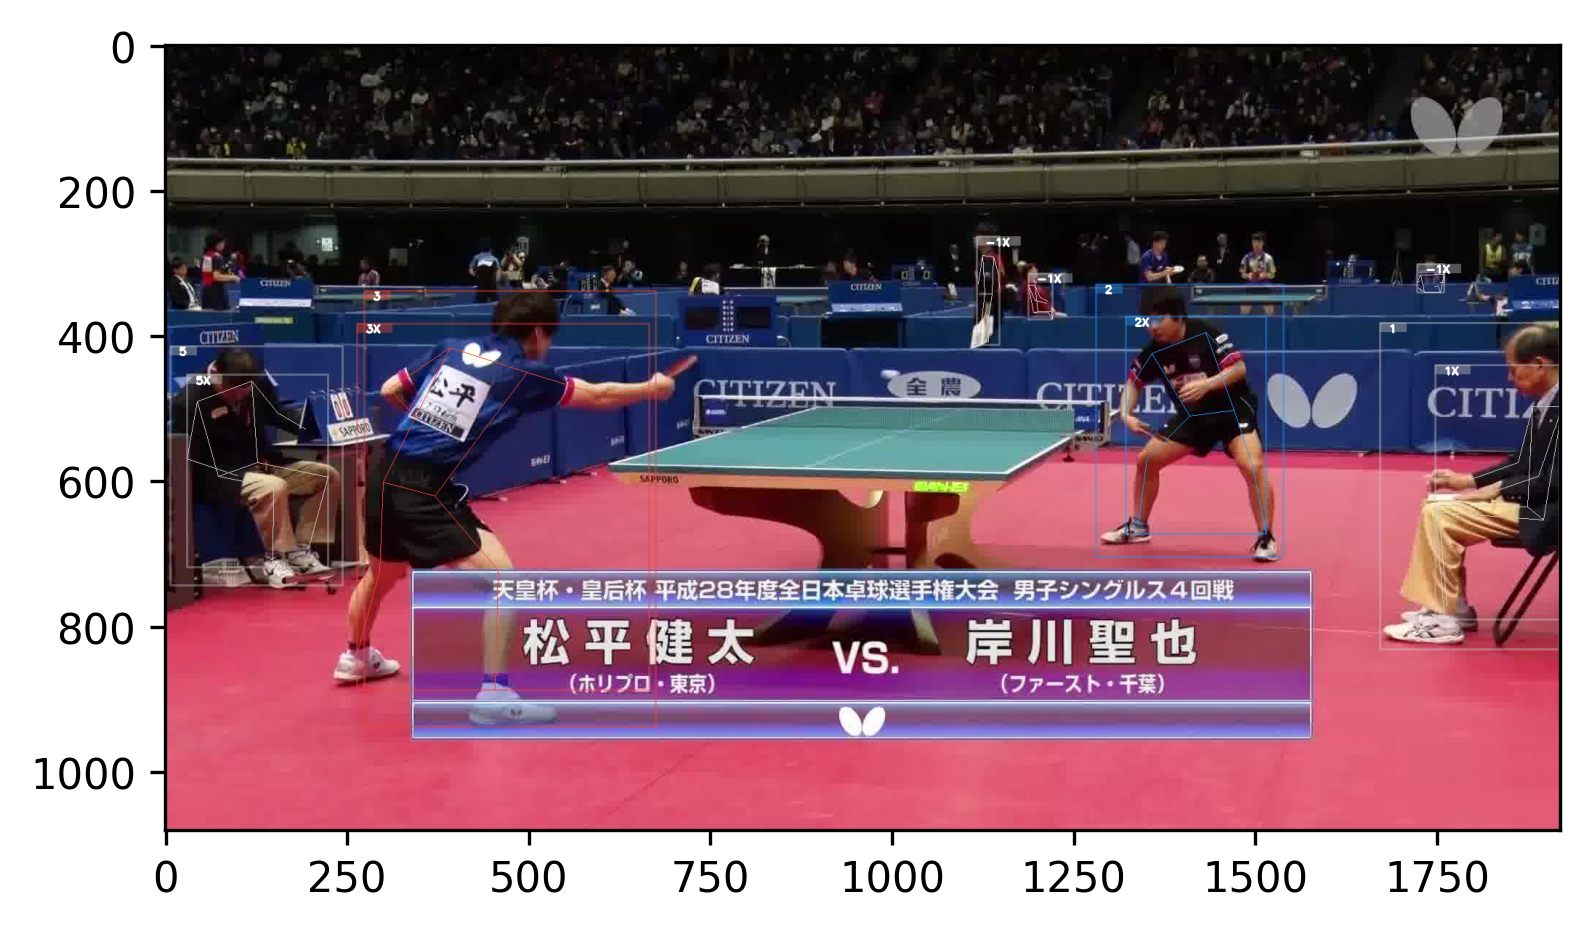

In [23]:
show_img_jupyter(im0)